## 1. Reading file

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")
BiocManager::install("ggplot2")
BiocManager::install("pheatmap")
BiocManager::install("ggfortify")
BiocManager::install("tsne")
install.packages("VennDiagram")

In [1]:
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(ggfortify)
library(tsne)
library(VennDiagram)

Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.1.3"
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

  

In [24]:
comparison.f <- function(te.mat,te.samp,g1=NULL,g2=NULL,met="TPM"){ 
    te.mat.TPM <- te.mat[,grep(met,colnames(te.mat))]
    colnames(te.mat.TPM) <- gsub("_TPM","",colnames(te.mat.TPM))
    rownames(te.mat.TPM) <- te.mat[,"Gene_Symbol"]
    if (!length(g1) | !length(g2))    return (te.mat.TPM)
    g1.samp <- te.samp[is.element(te.samp[,"Sample.Group"],g1),1]
    g2.samp <- te.samp[is.element(te.samp[,"Sample.Group"],g2),1]
    te.mat.TPM <- te.mat.TPM[,c(g1.samp,g2.samp)]
    com.re <- apply(te.mat.TPM,1,function(x){
        g1.exp <- as.double(as.matrix(x[g1.samp]))
        g2.exp <- as.double(as.matrix(x[g2.samp]))
        p.v <- t.test(g1.exp,g2.exp)$p.value
        fc <- mean(g2.exp) / mean(g1.exp)
        if (fc < 1)    fc <- -1 * (1/fc)
        cbind(p.v,fc)
    })
    if (nrow(com.re) == 2)    com.re <- t(com.re)
    colnames(com.re) <- c("P.value","FoldChange")
    f.re <- cbind(com.re,te.mat.TPM)
    #rownames(f.re) <- te.mat[,"Gene_Symbol"]
    return (f.re)
}

deseq.f <- function(te.mat,te.samp,g1=NULL,g2=NULL,exp=FALSE){
    te.mat.ct <- te.mat[,grep("_Read_Count",colnames(te.mat))]
    rownames(te.mat.ct) <- te.mat[,"Gene_Symbol"]
    colnames(te.mat.ct) <- gsub("_Read_Count","",colnames(te.mat.ct))
    te.mat.ct <- te.mat.ct[,te.samp[,"Sample.ID"]]
    if (length(g1) & length(g2)){
        te.samp <- te.samp[is.element(te.samp[,"Sample.Group"],c(g1,g2)),]
        te.mat.ct <- te.mat.ct[,te.samp[,"Sample.ID"]]
    }
    dds <- DESeqDataSetFromMatrix(countData=te.mat.ct,colData=te.samp,design=~Sample.Group)
    dds <- DESeq(dds)
    res <- results(dds)
    sig.mat <- as.matrix(res[,c("padj","log2FoldChange")])
    nms <- sig.mat[,"log2FoldChange"] < 0
    sig.mat[,"log2FoldChange"] <- 2^sig.mat[,"log2FoldChange"]
    sig.mat[nms,"log2FoldChange"] <- -1 * (1/sig.mat[nms,"log2FoldChange"])    
    dds.exp <- counts(dds,normalized=TRUE)
    exp.mat <- cbind(sig.mat,dds.exp[rownames(sig.mat),])
    colnames(exp.mat)[1:2] <- c("P.value","FoldChange")
    if (exp){
        exp.mat <- exp.mat[,-c(1:2)]
    }
    if (exp == "result")    return (res)
    return (exp.mat)
}

DEG.f <- function(dds.re,p=0.05,fc=1.5,met=NULL){
    p.v <- as.double(as.matrix(dds.re[,1]))
    if (length(met)){
        p.v <- p.adjust(p.v,met)
    }
    sig.p <- which(p.v < p)
    sig.fc <- which(abs(as.double(as.matrix(dds.re[,2]))) > fc)
    sig <- intersect(sig.p,sig.fc)
    sig.dds <- dds.re[sig,]
    return (sig.dds)
}

venn.f <- function(venn.li,out=NULL){
    f.li <- lapply(venn.li,function(x){
        rownames(x)
    })
    names(f.li) <- names(venn.li)
    venn.re <- venn.diagram(x=f.li,
        category.names = names(f.li),
        filename = out)
    if (!length(out)){
        grid.newpage()
        grid.draw(venn.re)
    }
}

subset.union.f <- function(total.li,total.exp){
    u.genes <- NULL
    for (i in 1:length(total.li)){
        u.genes <- c(u.genes,rownames(total.li[[i]]))
    }
    u.exp <- total.exp[unique(u.genes),]
    return (u.exp[,-c(1:2)])
}


vol.f <- function(te.exp,cut.pv,cut.fc,xl=NULL,yl=NULL,out=NULL){
    #cut.pv <- -log10(0.05)
    #cut.fc <- 1

    logp <- -log10(te.exp[,1])

    fc <- te.exp[,2]
    neg <- fc < 0
    fc[neg] <- 1/abs(fc[neg])
    fc <- log2(fc)

    thrs <- rep("Stable",length(logp))
    thrs[which(fc > cut.fc & logp > cut.pv)] <- "Up"
    thrs[which(fc < -1 * cut.fc & logp > cut.pv)] <- "Down"
    thrs[which(fc > -1 & fc < 1 * cut.fc & logp > cut.pv)] <- "SignificantNOtDEG"
    DEG <- factor(thrs,levels=c("Up","Down","SignificantNOtDEG","Stable"))

    gplot.df <- data.frame(x=fc,y=logp)
    gp <- ggplot(data=gplot.df, aes(x=x, y=y)) +
        geom_point(size=2,aes(color=DEG)) +
        theme(legend.position = "none") + 
        scale_color_manual(values=c("#F8766D","#7CAE00","#00BFC4","grey")) + 
        geom_vline(xintercept=c(-1*cut.fc,cut.fc),lty=4,col="black",lwd=0.8) + 
        geom_hline(yintercept=cut.pv,lty=4,col="black",lwd=0.8) +
        xlab("log2 fold change") + ylab("-log10 p-value") + theme_bw()
    if (length(xl)){
        gp <- gp + xlim(xl) + ylim(yl)
    }
    if (length(out)){
        png(out,width=2000,height=2000,res=300)
        print (gp)
        dev.off()
    }
    else{
        gp
    }
}

heatmap.f <- function(te.exp,Groups,rown=FALSE,out=NULL){
    te.exp <- te.exp[,is.element(colnames(te.exp),Groups[,1])]
    Groups <- cbind(Groups,Groups=gsub("[0-9]$","",Groups[,2]))
    colnames(Groups)[2] <- "Subgroups"
    rownames(Groups) <- Groups[,1]
    Groups <- Groups[colnames(te.exp),]
    #if (length(genes)){
    #    te.exp[genes,]
    #}
    gp <- pheatmap(te.exp,annotation_col=Groups[,2:3],scale="row",show_rownames=rown)
    if (length(out)){
        png(out,width=2000,height=2000,res=300)
        print (gp)
        dev.off()
    }
    else{
        gp
    }
}

cluster.f <- function(te.exp,Groups,g,met=NULL,out=NULL){
    te.exp <- te.exp[,is.element(colnames(te.exp),Groups[,1])]
    Groups <- cbind(Groups,Groups=gsub("[0-9]$","",Groups[,2]))
    colnames(Groups)[2] <- "Subgroups"
    rownames(Groups) <- Groups[,1]
    Groups <- Groups[colnames(te.exp),]
    var.val <- apply(te.exp,1,function(x)    var(x))
    te.exp <- te.exp[var.val != 0,]                 
    #if (length(genes)){
    #    te.exp[genes,]
    #}
    if (met == "PCA"){
        pca.cal.mat <- prcomp(t(te.exp),scale. = TRUE)
        gp <- autoplot(pca.cal.mat, data=Groups, colour = g) + theme_bw()
    }
    if (met == "tsne"){
        tsne.mat <- tsne(t(te.exp))
        colnames(tsne.mat) <- c("X1","X2")
        gp <- ggplot(data=tsne.mat,aes(x=X1,y=X2)) + geom_point(aes(color=Groups[,g])) + theme_bw() +
            scale_colour_discrete(name=g)
    }
    if (met == "MDS"){
        d <- dist(t(te.exp))
        fit <- cmdscale(d, eig=TRUE, k=length(unique(Groups[,g])))
        mds.mat <- fit$points
        colnames(mds.mat) <- paste0("X",1:length(unique(Groups[,g])))
        gp <- ggplot(data=mds.mat,aes(x=X1,y=X2)) + geom_point(aes(color=Groups[,g])) + theme_bw() +
            scale_colour_discrete(name=g)
    }
    if (length(out)){
        png(out,width=2000,height=2000,res=300)
        print (gp)
        dev.off()
    }
    else{
        gp
    }
}


In [3]:
macro.f <- "C:/Users/Home/Desktop/dt/1.data/MacroFile.txt"
macro.sample.f <- "C:/Users/Home/Desktop/dt/1.data/Macro_sample.txt"
aorta.f <- "C:/Users/Home/Desktop/dt/1.data/AortaFile.txt"
aorta.sample.f <- "C:/Users/Home/Desktop/dt/1.data/Aorta_sample.txt"

macro.dt <- read.csv(macro.f,sep='\t',header=T)
macro.samp <- read.csv(macro.sample.f,sep='\t',header=T)

aorta.dt <- read.csv(aorta.f,sep='\t',header=T)
aorta.samp <- read.csv(aorta.sample.f,sep='\t',header=T)

In [11]:
head(macro.dt)
head(macro.samp)

,Gene_ID,Transcript_ID,Gene_Symbol,Description,gene_biotype,Protein_ID,MGI,IMGT.GENE.DB,ApoEM0_1_FPKM,ApoEM0_3_FPKM,...,ApoEM2_4_Read_Count,DKOM0_1_Read_Count,DKOM0_3_Read_Count,DKOM0_4_Read_Count,DKOM1_1_Read_Count,DKOM1_3_Read_Count,DKOM1_4_Read_Count,DKOM2_1_Read_Count,DKOM2_3_Read_Count,DKOM2_4_Read_Count
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,11302,"NM_001198785,NM_001198787,NM_007377,XM_006531991,XM_006531992,XM_006531993,XM_006531994,XM_006531995,XM_030245475,XR_003949229",Aatk,apoptosis-associated tyrosine kinase,protein_coding,NP_001185714.1;NP_001185716.1;NP_031403.2;XP_006532054.1;XP_006532055.1;XP_006532056.1;XP_006532057.1;XP_006532058.1;XP_030101335.1,1197518,.,5.015915,4.665325,...,798,1890,1724,1757,2740,2617,3009,855,776,935
2,11303,"NM_013454,XM_006537554,XM_006537555,XM_006537556",Abca1,"ATP-binding cassette, sub-family A (ABC1), member 1",protein_coding,NP_038482.3;XP_006537617.1;XP_006537618.1;XP_006537619.1,99607,.,24.773225,26.829657,...,54612,22894,22031,22897,16047,13860,15758,51355,46391,53919
3,11305,"NM_001368624,NM_007379,XM_006497609,XM_006497610,XM_006497611,XM_006497614,XM_006497615,XM_006497616,XM_030246714,XM_030246727",Abca2,"ATP-binding cassette, sub-family A (ABC1), member 2",protein_coding,NP_001355553.1;NP_031405.2;XP_006497672.1;XP_006497673.1;XP_006497674.1;XP_006497677.1;XP_006497678.1;XP_006497679.1;XP_030102574.1;XP_030102587.1,99606,.,5.120971,5.525078,...,4564,3301,3012,3115,2509,2269,2809,4585,4111,5051
4,11306,NM_009592,Abcb7,"ATP-binding cassette, sub-family B (MDR/TAP), member 7",protein_coding,NP_033722.1,109533,.,14.200850,13.737722,...,3530,5921,5278,5301,2356,1900,2369,3145,2641,2950
5,11307,NM_009593,Abcg1,ATP binding cassette subfamily G member 1,protein_coding,NP_033723.1,107704,.,22.925264,27.028923,...,35124,13720,11888,11410,31101,27490,33087,40878,34455,42556
6,11308,"NM_001077190,NM_001077192,NM_001077193,NM_001331043,NM_001331044,NM_001331045,NM_007380,NM_145994,XM_006497619,XM_030246741",Abi1,abl-interactor 1,protein_coding,NP_001070658.1;NP_001070660.1;NP_001070661.1;NP_001317972.1;NP_001317973.1;NP_001317974.1;NP_031406.2;NP_666106.1;XP_006497682.1;XP_030102601.1,104913,.,64.963748,65.019330,...,11729,14957,14396,15138,10438,8551,10595,10480,9426,11316


,Sample.ID,Sample.Group
,<chr>,<chr>
1,DKOM0_1,DKOM0
2,DKOM0_3,DKOM0
3,DKOM0_4,DKOM0
4,ApoEM0_1,ApoEM0
5,ApoEM0_3,ApoEM0
6,ApoEM0_4,ApoEM0


## 2. DEG analysis with DESeq2

In [12]:
D0.A0.des <- comparison.f(macro.dt,macro.samp,"DKOM0","ApoEM0")
D0.A0.sig <- DEG.f(D0.A0.des,0.05,2,"fdr")

In [59]:
#T.total.exp <- deseq.f(aorta.dt,aorta.samp)
#T.total.TPM <- comparison.f(aorta.dt,aorta.samp)
T.total.FPKM <- comparison.f(aorta.dt,aorta.samp,"FPKM")

In [16]:
D0.A0.des <- deseq.f(macro.dt,macro.samp,"DKOM0","ApoEM0")
D1.A1.des <- deseq.f(macro.dt,macro.samp,"DKOM1","ApoEM1")
D2.A2.des <- deseq.f(macro.dt,macro.samp,"DKOM2","ApoEM2")
A0.A1.des <- deseq.f(macro.dt,macro.samp,"ApoEM0","ApoEM1")
A0.A2.des <- deseq.f(macro.dt,macro.samp,"ApoEM0","ApoEM2")
D0.D1.des <- deseq.f(macro.dt,macro.samp,"DKOM0","DKOM1")
D0.D2.des <- deseq.f(macro.dt,macro.samp,"DKOM0","DKOM2")

D0.A0.sig <- DEG.f(D0.A0.des,0.05,2)
D1.A1.sig <- DEG.f(D1.A1.des,0.05,2)
D2.A2.sig <- DEG.f(D2.A2.des,0.05,2)
A0.A1.sig <- DEG.f(A0.A1.des,0.05,2)
A0.A2.sig <- DEG.f(A0.A2.des,0.05,2)
D0.D1.sig <- DEG.f(D0.D1.des,0.05,2)
D0.D2.sig <- DEG.f(D0.D2.des,0.05,2)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in 

In [13]:
total.exp <- deseq.f(macro.dt,macro.samp)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [175]:
write.table(rownames(total.exp),"C:/Users/Home/Desktop/dt/total.set.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(D0.A0.sig),"C:/Users/Home/Desktop/dt/D0.A0.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(D1.A1.sig),"C:/Users/Home/Desktop/dt/D1.A1.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(D2.A2.sig),"C:/Users/Home/Desktop/dt/D2.A2.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(A0.A1.sig),"C:/Users/Home/Desktop/dt/A0.A1.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(A0.A2.sig),"C:/Users/Home/Desktop/dt/A0.A2.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(D0.D1.sig),"C:/Users/Home/Desktop/dt/D0.D1.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)
write.table(rownames(D0.D2.sig),"C:/Users/Home/Desktop/dt/D0.D2.sig.txt",sep='\t',quote=F,row.names=F,col.names=F)


## 3. Venn Diagram

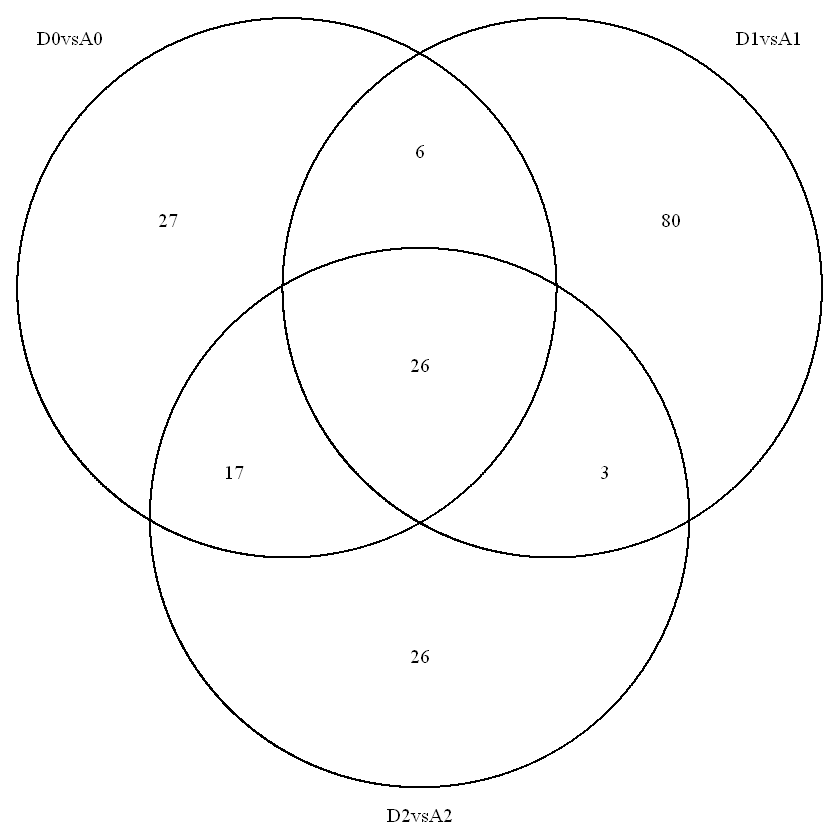

In [22]:
total.li <- list("D0vsA0"=D0.A0.sig,
                "D1vsA1"=D1.A1.sig,
                "D2vsA2"=D2.A2.sig,
                "A0vsA1"=A0.A1.sig,
                "A0vsA2"=A0.A2.sig,
                "D0vsD1"=D0.D1.sig,
                "D0vsD2"=D0.D2.sig
)
inter.g <- c("D0vsA0","A0vsA1","D0vsD2")
venn.f(total.li[inter.g],out="C:/Users/Home/Desktop/dt/venn.png")

## 4. Volcano plot

Warning message:
"Removed 841 rows containing missing values (geom_point)."


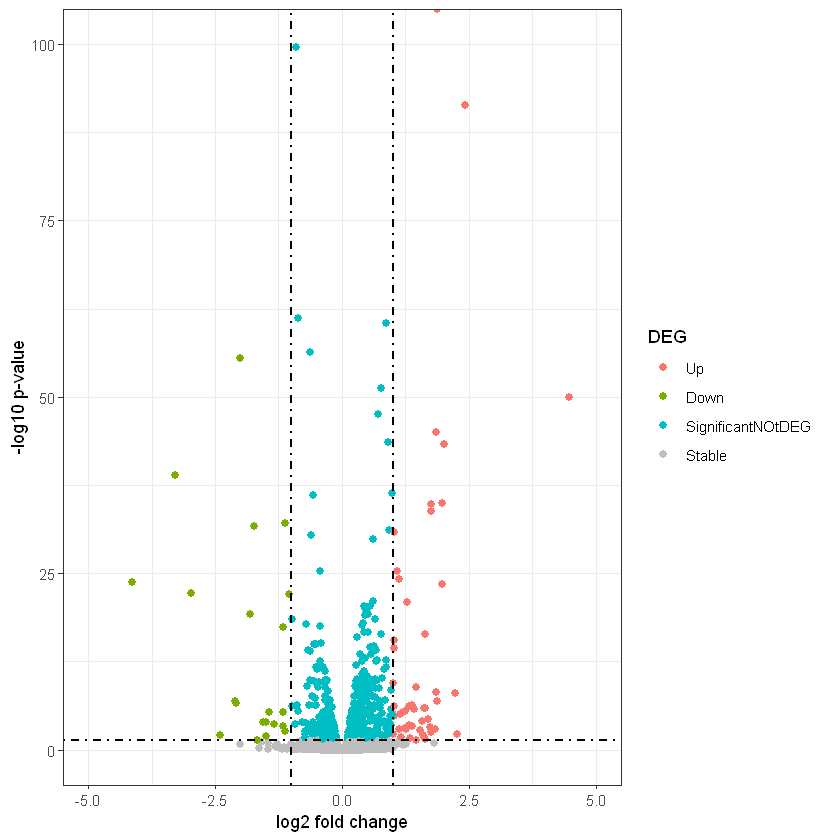

In [26]:
#vol.f(D0.A0.des,cut.pv=-log10(0.05),cut.fc=1,xl=c(-5,5),yl=c(0,100),out="C:/Users/Home/Desktop/dt/vol.png")
#vol.f(D0.A0.des,cut.pv=-log10(0.05),cut.fc=1)
vol.f(D0.A0.des,cut.pv=-log10(0.05),cut.fc=1,xl=c(-5,5),yl=c(0,100))

## 5. Heat Map

In [70]:
total.sig.exp <- subset.union.f(total.li,total.exp)
head(total.sig.exp)

,DKOM0_1,DKOM0_3,DKOM0_4,ApoEM0_1,ApoEM0_3,ApoEM0_4,DKOM1_1,DKOM1_3,DKOM1_4,ApoEM1_1,ApoEM1_3,ApoEM1_4,DKOM2_1,DKOM2_3,DKOM2_4,ApoEM2_1,ApoEM2_3,ApoEM2_4
Arg1,80.51745,107.6816,78.80016,38.98353,47.99113,34.83798,4352.4613,4459.8318,3941.6212,3233.3475,3545.61468,2961.06978,157616.0402,159877.40846,166074.18103,142096.70168,140465.04007,142145.20118
Atp9a,103.75960,120.5008,122.86046,43.56983,48.97054,39.96121,205.3261,202.5491,176.0129,100.3640,77.20019,82.04238,141.6223,115.70627,126.64911,58.98068,48.95651,44.43899
C4b,364.40371,296.5516,230.46929,108.54237,177.27335,159.84486,2241.6642,2489.3539,2512.1835,2700.3334,3079.05699,3162.87517,116.5735,79.34144,68.19567,47.85225,55.81042,42.54797
Camk2b,204.19889,151.2670,183.86704,104.72046,53.86759,68.65132,1053.7063,1090.2645,1068.8781,583.1961,624.31461,605.41618,456.6598,502.49578,446.37169,217.00439,227.15821,205.17576
Cd59a,760.35033,820.4310,895.61042,358.49558,423.10546,361.70022,418.5493,500.1213,500.3032,241.4160,208.10487,249.89920,661.8677,663.38259,673.10017,288.22635,265.34429,248.66924
Cxcr4,1224.36325,1380.2042,1091.33985,4681.84529,5132.11254,4491.02564,1585.0721,1616.6422,1666.2550,3238.7726,2820.60417,3131.75565,4786.2573,4950.02425,4289.24224,10422.88788,9671.84816,9100.53787


png 
  2

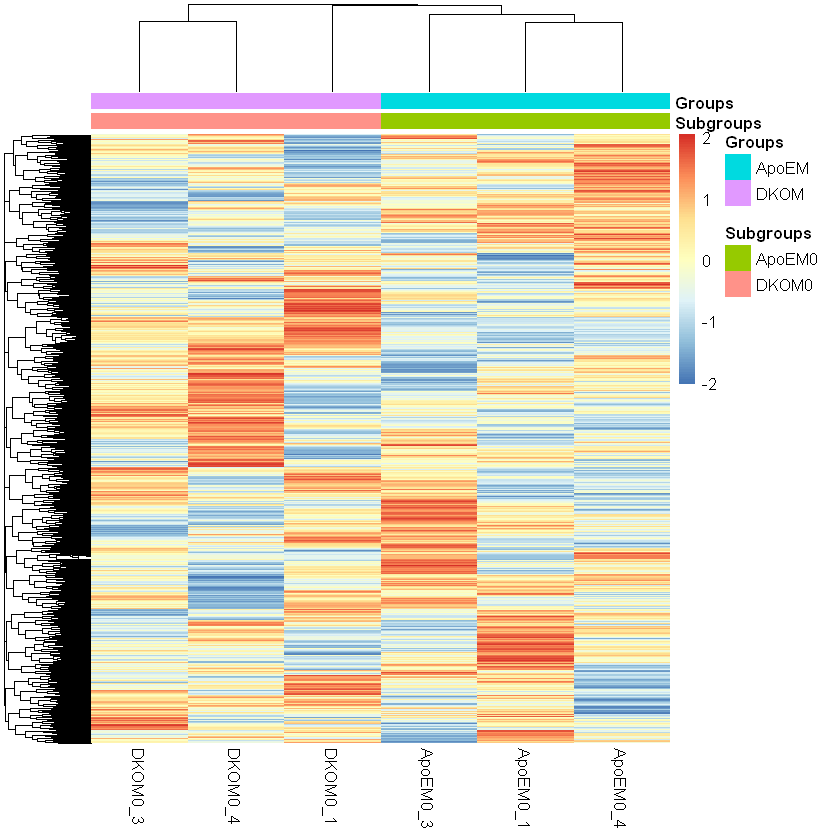

png 
  2

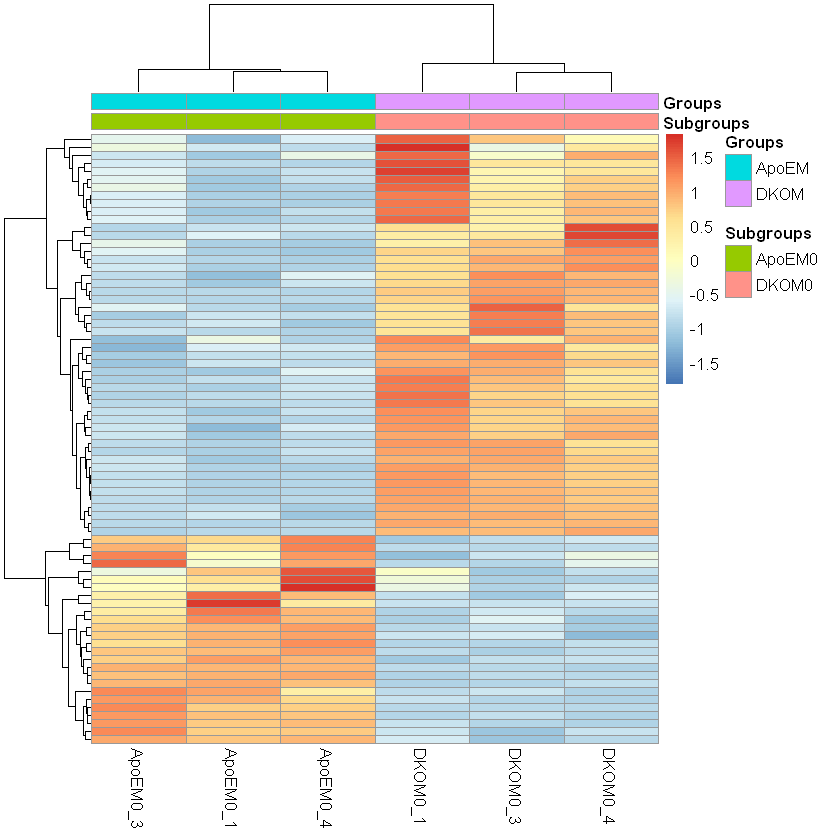

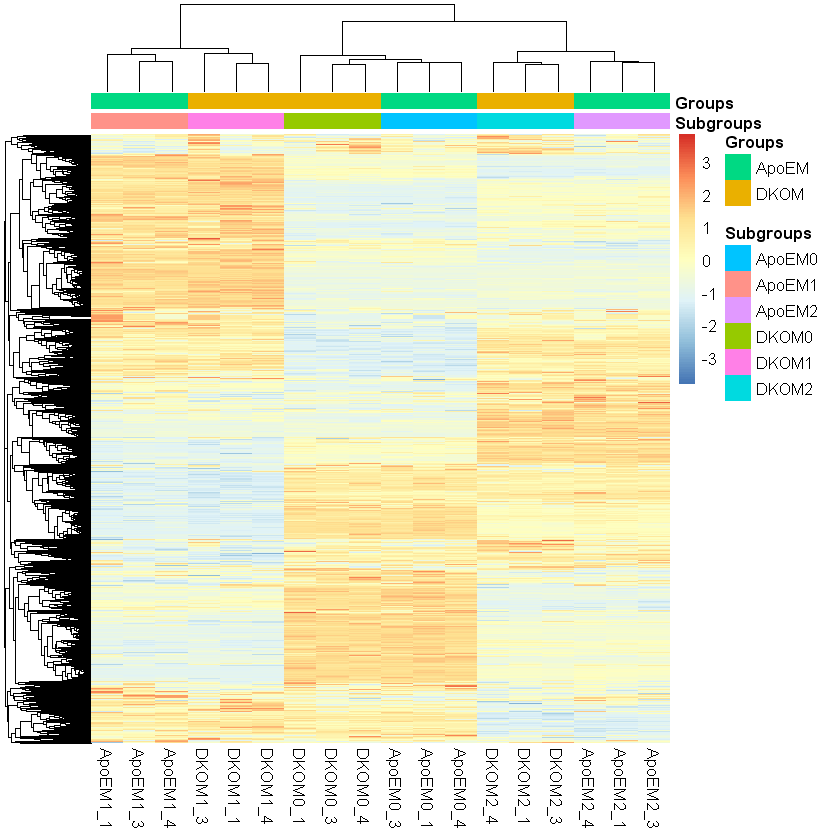

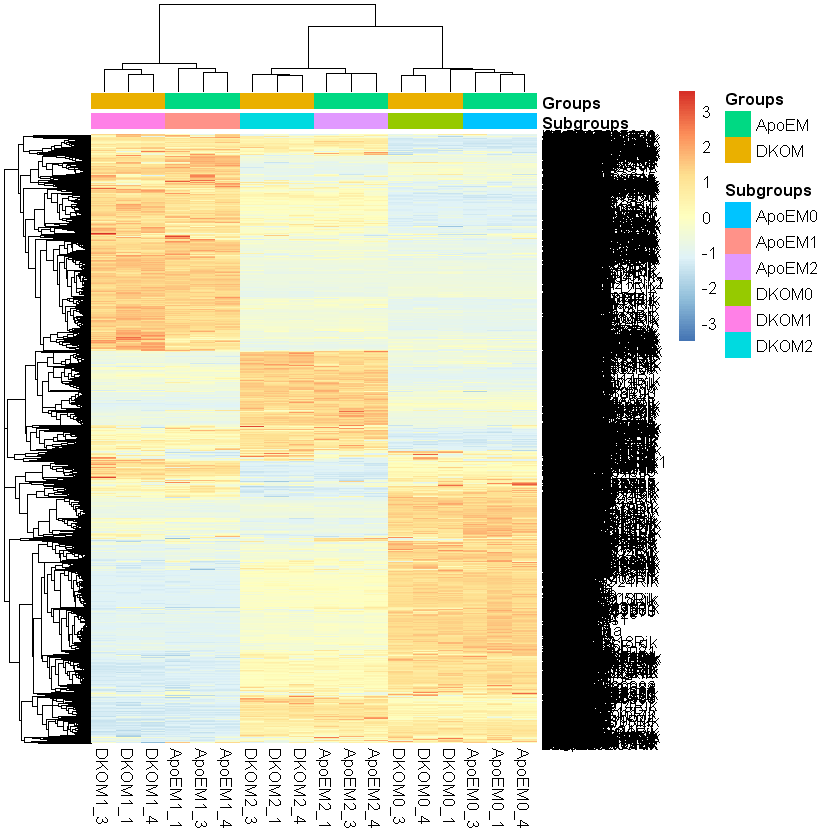

In [84]:
heatmap.f(D0.A0.des,macro.samp)
heatmap.f(D0.A0.sig,macro.samp,rown=TRUE,out="C:/Users/Home/Desktop/dt/heatmap.png")
heatmap.f(total.exp,macro.samp)
heatmap.f(total.sig.exp,macro.samp)

## 6. PCA

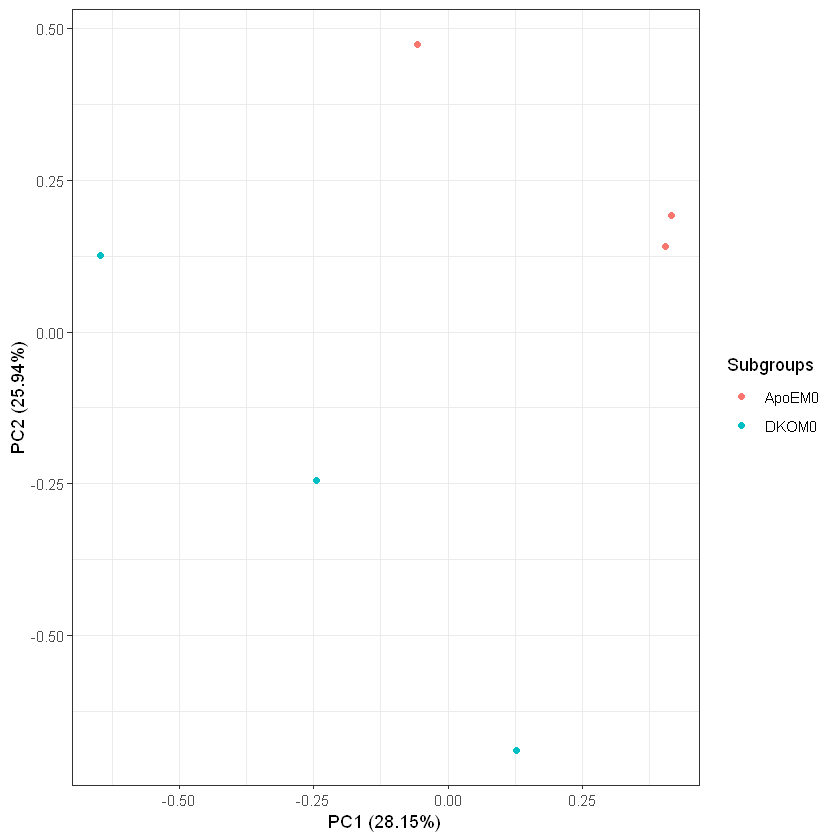

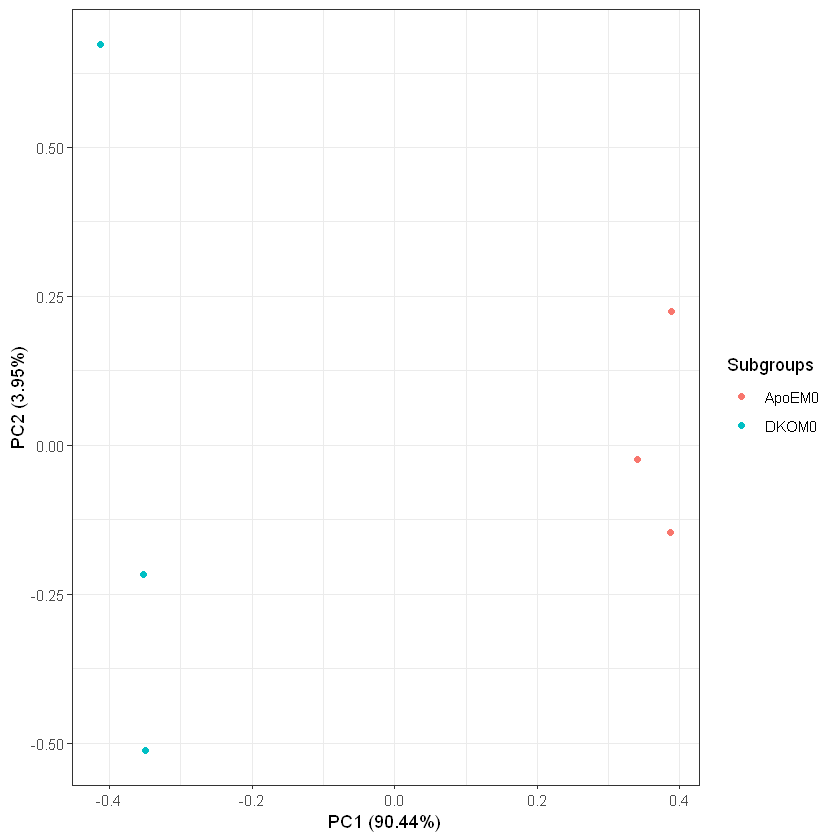

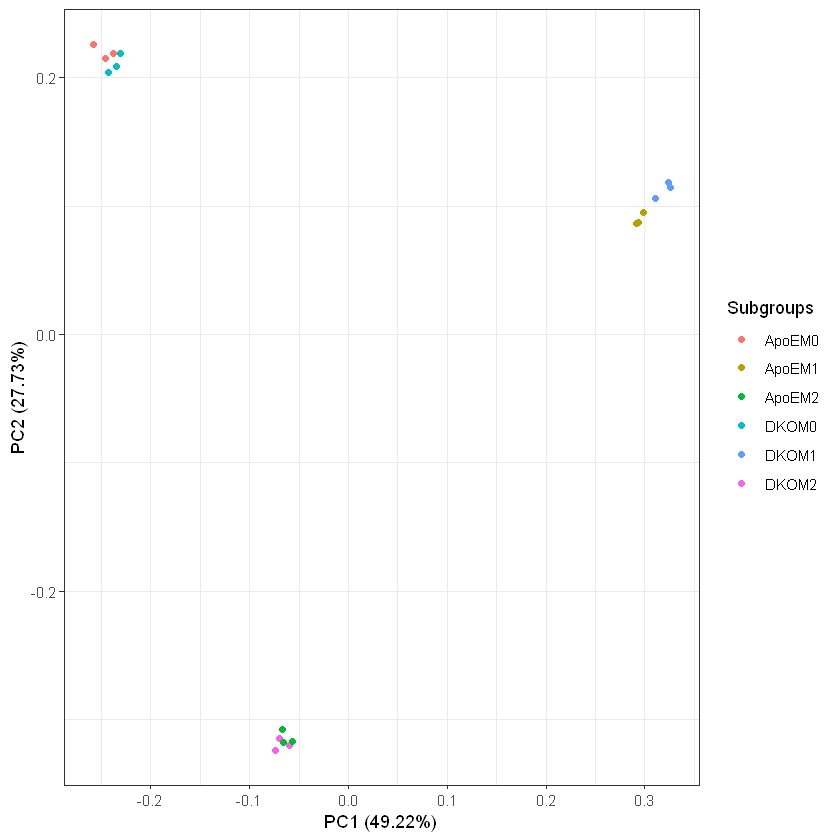

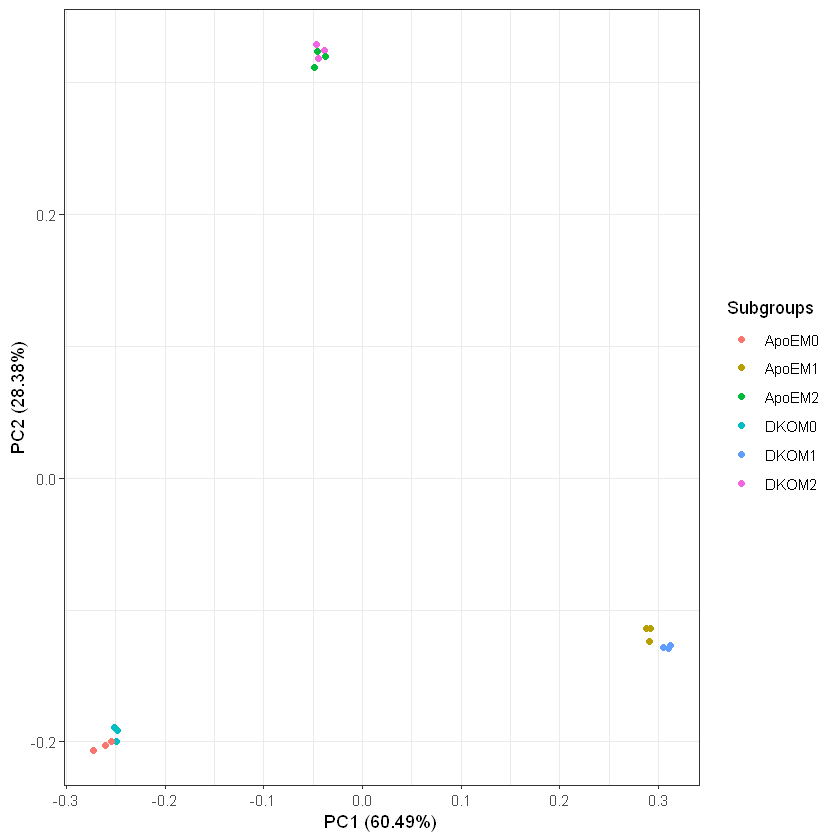

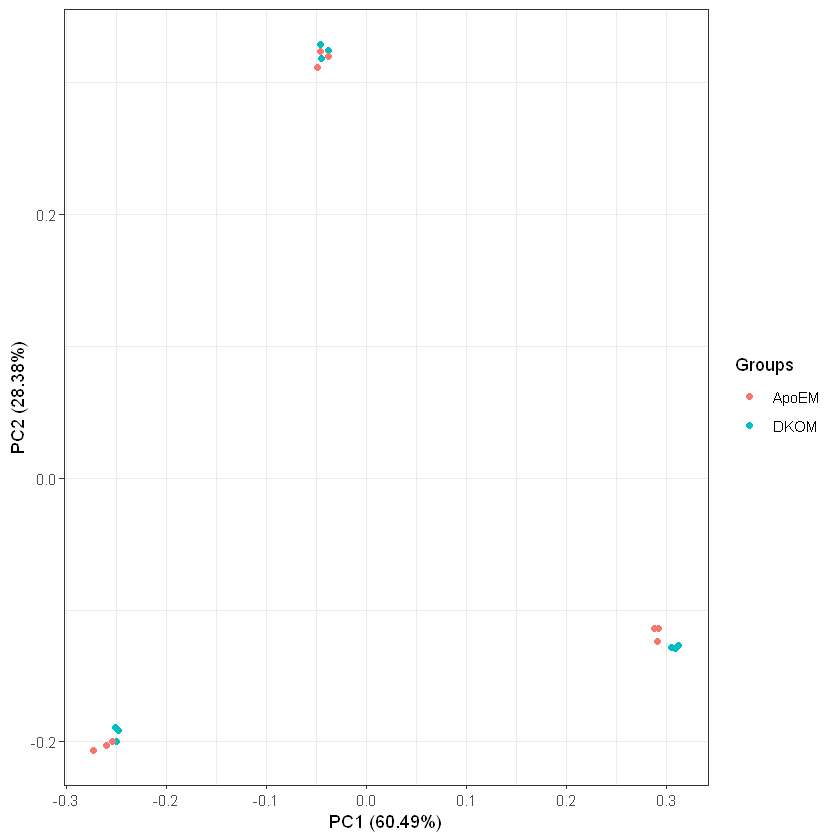

In [78]:
cluster.f(D0.A0.des,macro.samp,g="Subgroups",met="PCA")
cluster.f(D0.A0.sig,macro.samp,g="Subgroups",met="PCA")
cluster.f(total.exp,macro.samp,g="Subgroups",met="PCA")
cluster.f(total.sig.exp,macro.samp,g="Subgroups",met="PCA")

cluster.f(total.sig.exp,macro.samp,g="Groups",met="PCA")

sigma summary: Min. : 33554432 |1st Qu. : 33554432 |Median : 33554432 |Mean : 33554432 |3rd Qu. : 33554432 |Max. : 33554432 |

Epoch: Iteration #100 error is: 9.79236797794365

Epoch: Iteration #200 error is: 0.194767851789476

Epoch: Iteration #300 error is: 0.132680975901151

Epoch: Iteration #400 error is: 0.131013839721735

Epoch: Iteration #500 error is: 0.131013684901408

Epoch: Iteration #600 error is: 0.131013684864489

Epoch: Iteration #700 error is: 0.131013684857478

Epoch: Iteration #800 error is: 0.131013684846219

Epoch: Iteration #900 error is: 0.131013684830845

Epoch: Iteration #1000 error is: 0.131013684811401



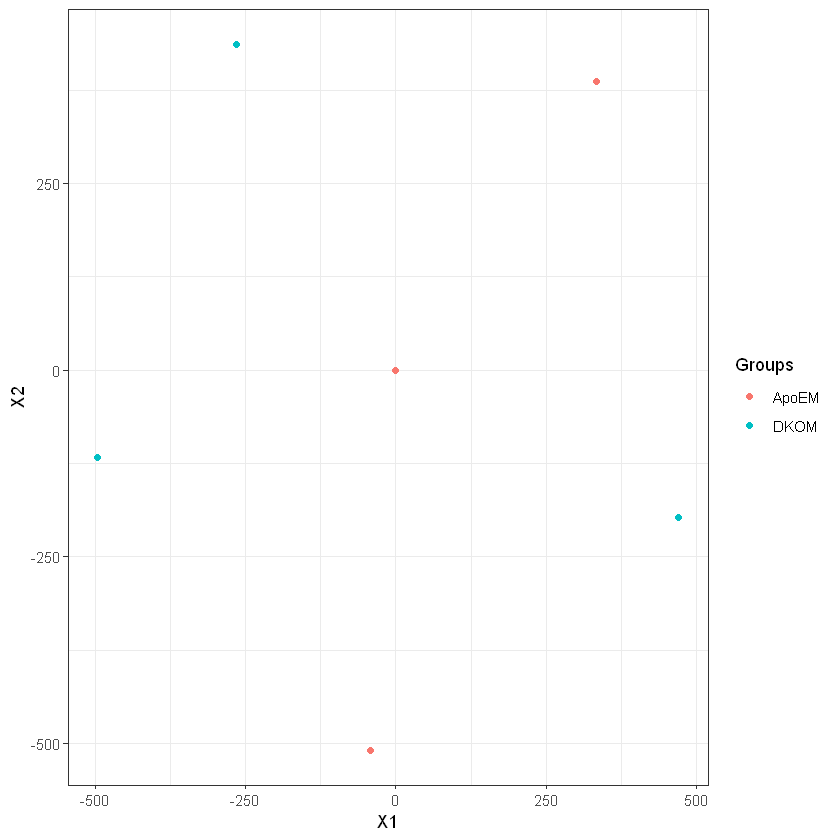

In [116]:
cluster.f(D0.A0.sig,macro.samp,g="Groups",met="tsne")

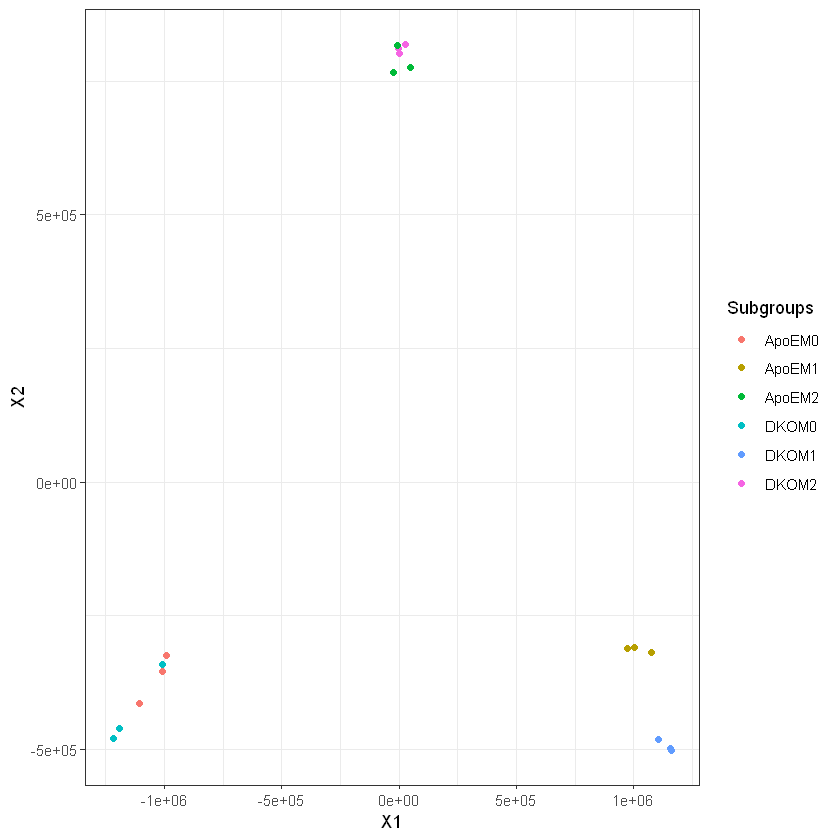

In [174]:
cluster.f(total.sig.exp,macro.samp,g="Subgroups",met="MDS")

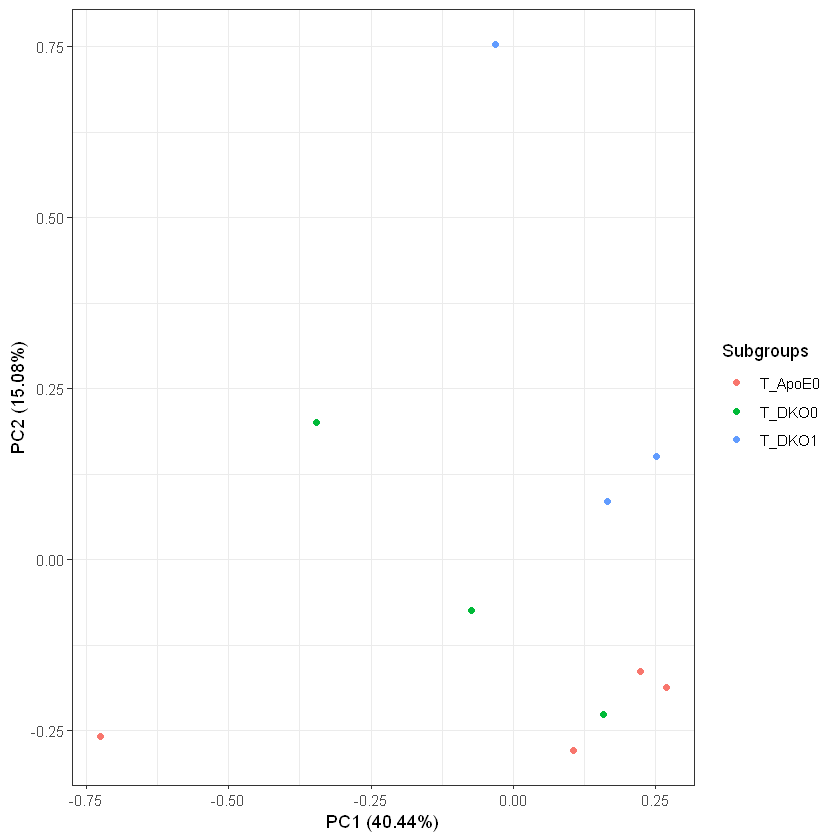

In [62]:
cluster.f(T.total.FPKM,aorta.samp,g="Subgroups",met="PCA")